<img src="../DATA/corp_logo.jpg" width='160'>

# WaterShed Algorithm (Image Segmentation)

A grayscale image can be viewed as a topographical surface where **high intensity** denotes peaks and **low intensity** denotes valleys. The algorithm can fill every isolated valleys(local minima) with different colored waters(labels).

As the "water" rises, depending on the peaks(gradients) nearby, "water" from different valleys(different segments of the image), with different colors could start to be merged. To avoid this, the algorithm creates **barriers** (segment edge boundries) in locations **where "water" merges**.

- This algorithm is especially useful for segmenting images into background and foreground in situations that are difficult for other algorithms.
- Later on we provide custom "seeds" that allow us to manually start where the valleys of the watershed go.

---

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

### Common Coin Example

**GOAL:** Drawing contours around the coins

### Naive Approach
using a threshold and then use findcontours.

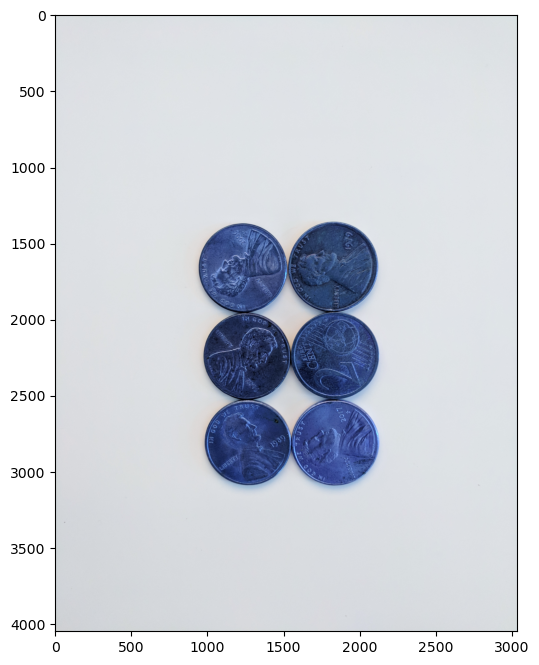

In [3]:
sep_coins = cv2.imread('../DATA/pennies.jpg')
display(sep_coins)

### Median Blurring
There is too much **details** like light, the face edges on the coins, and too much detail in background can be **blurred**. It is useful when we **apply thresholding**.

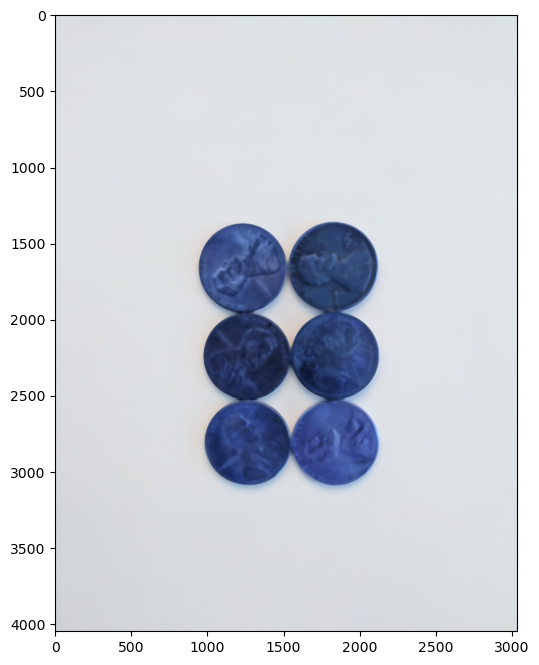

In [4]:
# For big-size images, big kernels is recommended (25)
sep_blur = cv2.medianBlur(sep_coins,25)
display(sep_blur)

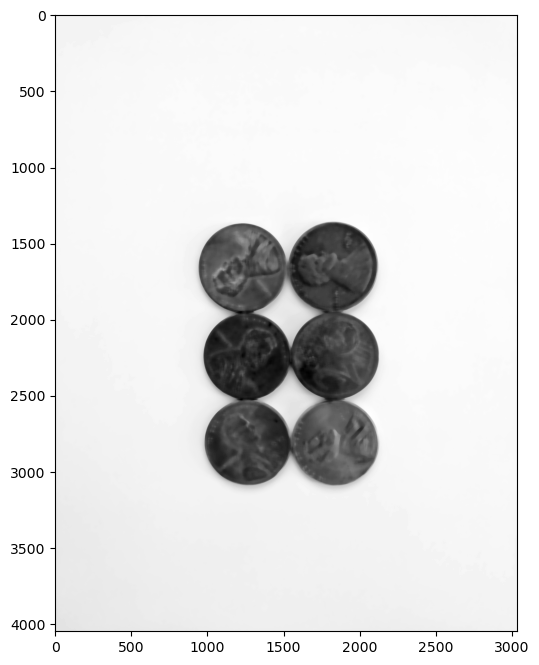

In [5]:
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)
display(gray_sep_coins,cmap='gray')

### Binary Threshold

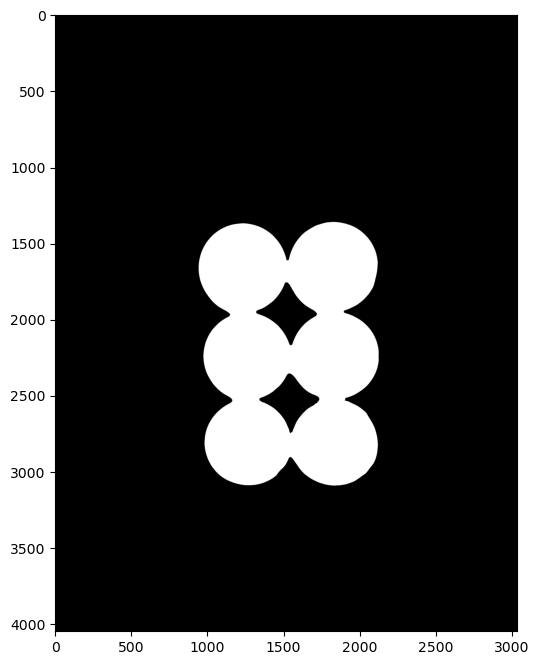

In [6]:
ret, sep_thresh = cv2.threshold(gray_sep_coins,160, 255,cv2.THRESH_BINARY_INV)
#ret, sep_thresh = cv2.threshold(gray_sep_coins,160, 255,cv2.THRESH_OTSU)
display(sep_thresh,cmap='gray')

# In this part, primarily I used a OTSU thersholding, and then a CLOSING morphological operator. 
# But not a good result obtained at the end! 

### Noise Removal (Opening-->Black pixels are opened!)

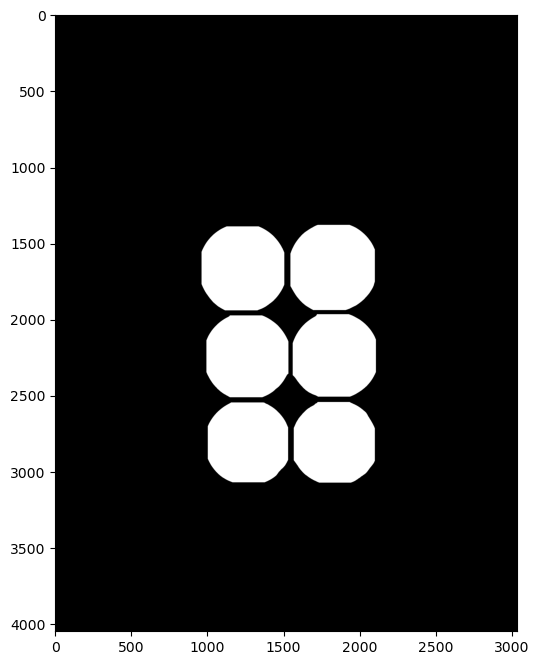

In [7]:
# noise removal
kernel = np.ones((7,7),np.uint8)
opening = cv2.morphologyEx(sep_thresh,cv2.MORPH_OPEN,kernel, iterations = 35)
display(opening,cmap='gray')

### Find Contours

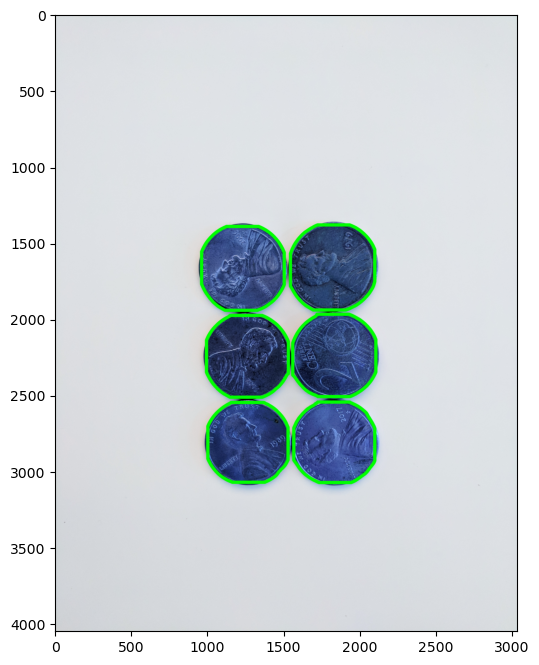

In [8]:
contours, hierarchy = cv2.findContours(opening.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

sep_coins_contours = sep_coins.copy()
# # For every entry in contours
# for i in range(len(contours)):
    
#     # last column in the array is -1 if an external contour (no contours inside of it)
#     if hierarchy[0][i][3] == -1:
        
#         # We can now draw the external contours from the list of contours
#         cv2.drawContours(sep_coins_contours, contours, i, (0, 255, 0), 20)

cv2.drawContours(image=sep_coins_contours, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
display(sep_coins_contours)

---

### Watershed Algorithm

#### 1. Image Read

In [9]:
img = cv2.imread('../DATA/pennies.jpg')

#### 2. Blurring

In [10]:
# Larger kernel size for larger images
img = cv2.medianBlur(img,35)

#### 3. Convert to Grayscale

In [11]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#### 4. Apply Threshold (Inverse Binary with OTSU as well)

https://learnopencv.com/otsu-thresholding-with-opencv/

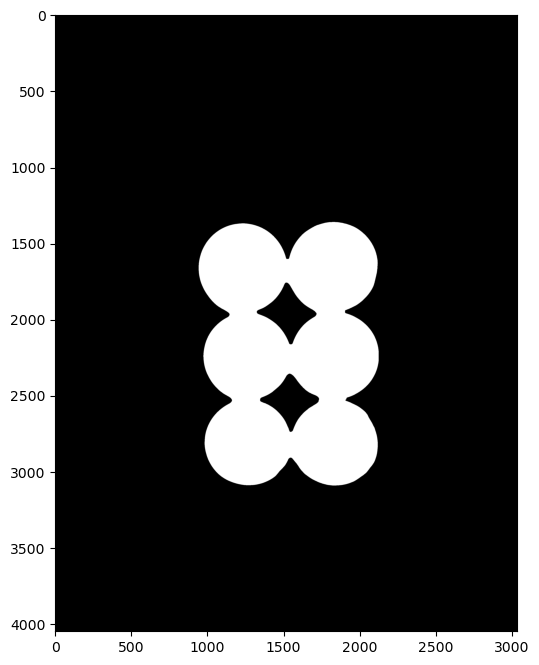

In [12]:
ret, thresh = cv2.threshold(gray,160,255,cv2.THRESH_BINARY_INV)

# We can also use:
# ret, thresh = cv2.threshold(gray,160,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

display(thresh,cmap='gray')

#### Optional: 5. Noise Removal

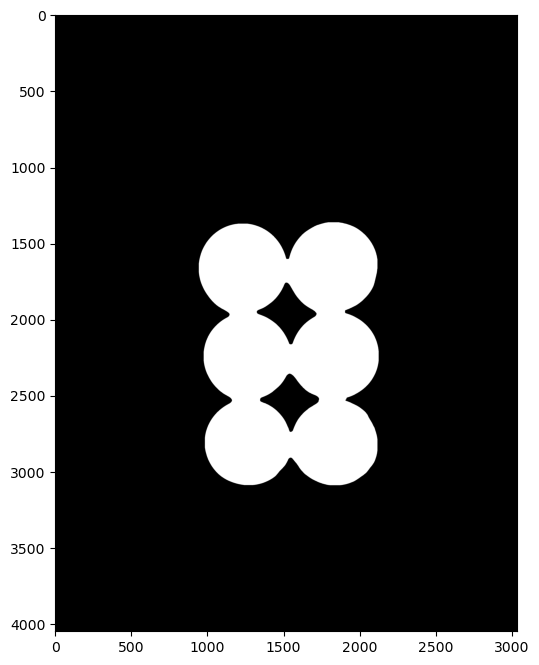

In [13]:
# noise removal
kernel = np.ones((7,7),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 10)

display(opening,cmap='gray')

#### Step 6: Grab Background that you are sure of

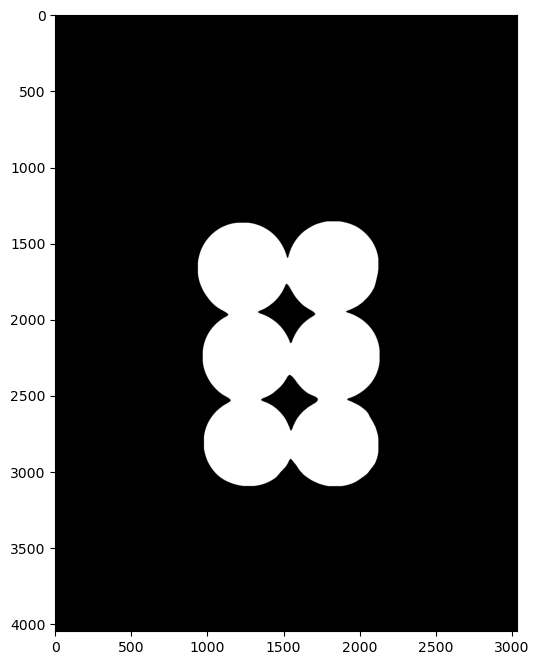

In [14]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=2)

display(sure_bg,cmap='gray')

#### Step 7: Find Sure Foreground
Links for distance transformation:

- https://en.wikipedia.org/wiki/Distance_transform
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/distance.htm

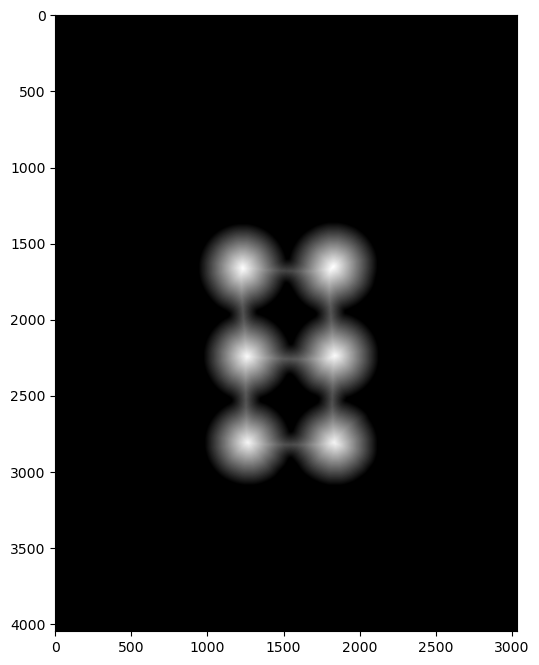

In [15]:
# Finding sure foreground area   
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

display(dist_transform,cmap='gray')

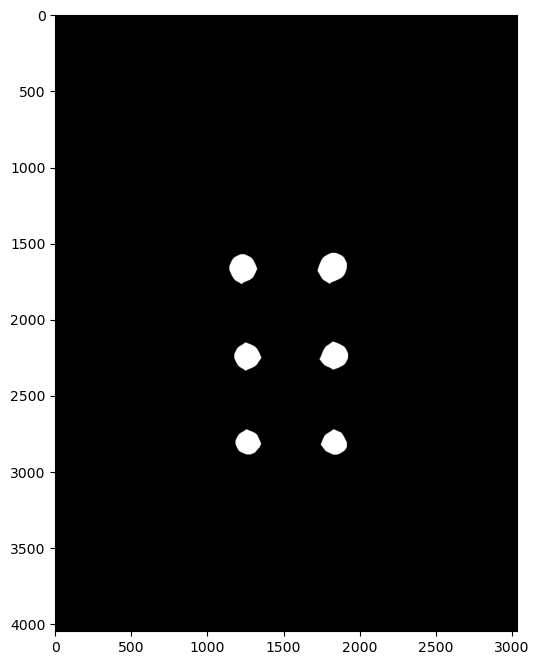

In [16]:
display(sure_fg,cmap='gray')

#### 8. Find Unknown Region

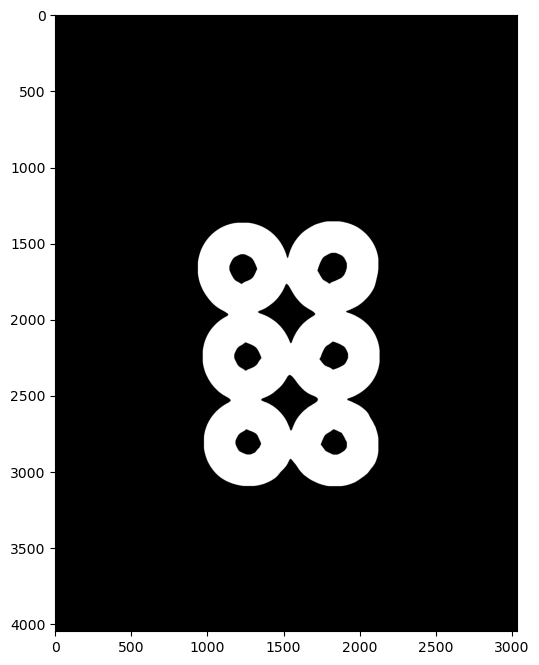

In [17]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

display(unknown,cmap='gray')

#### 9. Label Markers of Sure Foreground

`markers`: This is a labeled image where each connected component is assigned a **unique integer label**. The **background pixels** are typically labeled as `0`.

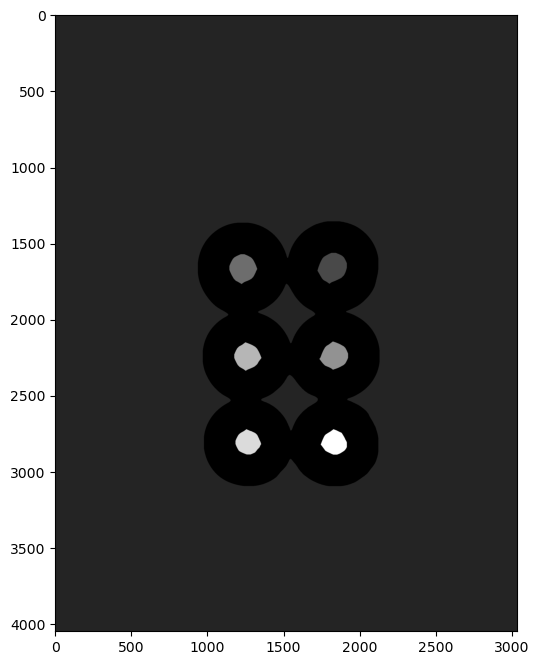

In [18]:
# Marker labelling for Watershed Algorithm as Seeds
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

display(markers,cmap='gray')

#### 10. Apply Watershed Algorithm to find Markers

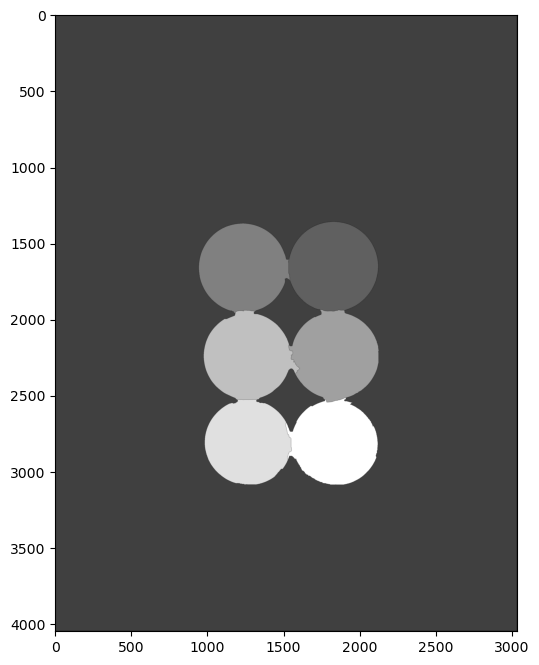

In [19]:
markers = cv2.watershed(img,markers)

display(markers, cmap='gray')

#### 11. Find Contours on Markers

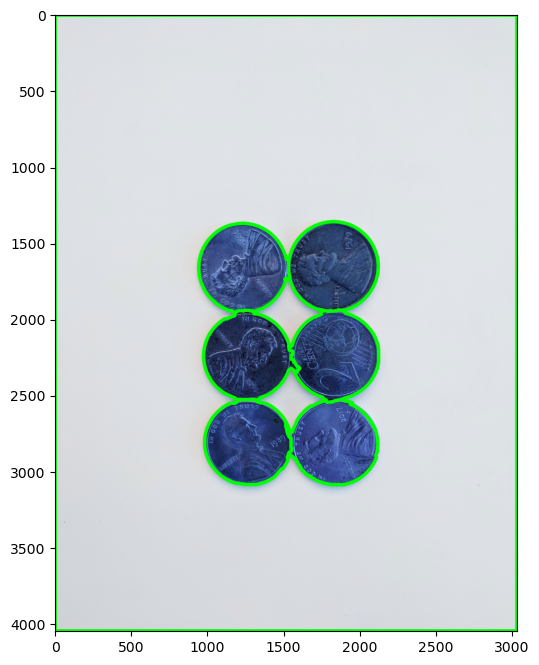

In [20]:
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

sep_coins_contours = sep_coins.copy()
# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(sep_coins_contours, contours, i, (0, 255, 0), 20)

display(sep_coins_contours)

- Notice that it segmented all around the image just the general background itself.

In [23]:
contours[0].shape

(783, 1, 2)